# Scale Detection
Train a model to detect the scale of an image relative to the scale of the training dataset for a model.

In [1]:
import os
import errno

import numpy as np

import deepcell

In [2]:
# create folder for this set of experiments
experiment_folder = "20200619_production_updates"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

## Load the training data

Download data for nuclear, brightfield and fluorescent cytoplasm from `deepcell.datasets` and combine the data into a single training dataset.

In [31]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20200514_IF_Training_8"
npz_name = "20200521_IF_Training_256"
npz_name = "20200803_all_data_normalized_512x512"
# npz_name = '20200615_ML_256x256'

test_size=0.1
seed=0
DATA_FILE = NPZ_DIR + npz_name + ".npz"
train_dict, val_dict = get_data(DATA_FILE, test_size=test_size, seed=seed)
X_train, y_train = train_dict['X'], train_dict['y']
X_val, y_val = val_dict['X'], val_dict['y']

In [33]:
X_train = X_train[:, :256, :256, :]
X_val = X_val[:, :256, :256, :]

y_train = y_train[:, :256, :256, :]
y_val = y_val[:, :256, :256, :]

## Create the Scale Detection Model

We are using the ScaleDetectionModel from `deepcell.applications`

In [34]:
from deepcell.applications import ScaleDetectionModel

# set use_pretrained_weights to False to retrain from scratch
model = ScaleDetectionModel(
    backbone='mobilenetv2',
    input_shape=X_train.shape[1:],
    use_pretrained_weights=False)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
image_normalization2d_3 (ImageN (None, 256, 256, 2)  0           input_4[0][0]                    
__________________________________________________________________________________________________
tensor_product_9 (TensorProduct (None, 256, 256, 3)  9           image_normalization2d_3[0][0]    
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           tensor_product_9[0][0]           
____________________________________________________________________________________________

In [18]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

n_epoch = 20
batch_size = 64
lr = 1e-3

optimizer = Adam(lr=lr, clipnorm=.001)
lr_sched = rate_scheduler(lr=lr, decay=0.9)

model.compile(optimizer, loss='mse', metrics=['mae', 'mape'])
MODEL_NAME = npz_name + '_scale_detection'
print(MODEL_NAME)

20200803_all_data_normalized_512x512_scale_detection


## Train the Model

Create the ImageDataGenerators and pass them to `model.fit_generator`.

In [19]:
from deepcell.image_generators import ScaleDataGenerator

# Create the image data generator for training

generator = ScaleDataGenerator(
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=(0.25, 4)
)

In [20]:
from tensorflow.python.keras import callbacks

model.fit_generator(
    generator.flow({'X': X_train, 'y': y_train}, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=generator.flow({'X': X_val, 'y': y_val}, batch_size=batch_size),
    validation_steps=X_val.shape[0] // batch_size,
    callbacks=[
        callbacks.LearningRateScheduler(lr_sched),
        callbacks.ModelCheckpoint(
            os.path.join(MODEL_DIR, MODEL_NAME + '.h5'),
            verbose=1,
            monitor='val_loss',
            save_best_only=True)
    ]
)

Epoch 1/20


W0804 00:29:58.687999 139817461872448 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/clip_ops.py:157: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


31/32 [============================>.] - ETA: 0s - loss: 1.9946 - mean_absolute_error: 1.1466 - mean_absolute_percentage_error: 86.6489
Epoch 00001: val_loss improved from inf to 5.12802, saving model to /data/models/20200619_production_updates/20200803_all_data_normalized_512x512_scale_detection.h5
32/32 [==============================] - 52s 2s/step - loss: 1.9893 - mean_absolute_error: 1.1443 - mean_absolute_percentage_error: 88.1308 - val_loss: 5.1280 - val_mean_absolute_error: 1.9971 - val_mean_absolute_percentage_error: 97.4134
Epoch 2/20
31/32 [============================>.] - ETA: 0s - loss: 1.3404 - mean_absolute_error: 0.9751 - mean_absolute_percentage_error: 90.0329
Epoch 00002: val_loss improved from 5.12802 to 4.56915, saving model to /data/models/20200619_production_updates/20200803_all_data_normalized_512x512_scale_detection.h5
32/32 [==============================] - 15s 460ms/step - loss: 1.3423 - mean_absolute_error: 0.9760 - mean_absolute_percentage_error: 89.0955 -

32/32 [==============================] - 14s 425ms/step - loss: 1.1791 - mean_absolute_error: 0.9351 - mean_absolute_percentage_error: 82.1719 - val_loss: 1.2410 - val_mean_absolute_error: 0.9540 - val_mean_absolute_percentage_error: 74.6716
Epoch 17/20
31/32 [============================>.] - ETA: 0s - loss: 1.1575 - mean_absolute_error: 0.9315 - mean_absolute_percentage_error: 84.4564
Epoch 00017: val_loss improved from 1.24102 to 1.21401, saving model to /data/models/20200619_production_updates/20200803_all_data_normalized_512x512_scale_detection.h5
32/32 [==============================] - 13s 417ms/step - loss: 1.1552 - mean_absolute_error: 0.9294 - mean_absolute_percentage_error: 83.8668 - val_loss: 1.2140 - val_mean_absolute_error: 0.9558 - val_mean_absolute_percentage_error: 68.7755
Epoch 18/20
31/32 [============================>.] - ETA: 0s - loss: 1.1479 - mean_absolute_error: 0.9158 - mean_absolute_percentage_error: 83.9269
Epoch 00018: val_loss did not improve from 1.21401


## Run the model on test data

Run the model on validation data and visualize the performance.

In [13]:
model.load_weights(os.path.join(MODEL_DIR, MODEL_NAME + '.h5'))

test_data = generator.flow({'X': X_test, 'y': y_test}, batch_size=1)

true, pred = [], []
for i in range(1000):
    if i % 100 == 0:
        print(".", end="")

    X, y = test_data.next()
    true.append(y)
    pred.append(model.predict(X))
    
true = np.array(true)
pred = np.array(pred)

..........

Text(0, 0.5, 'Error')

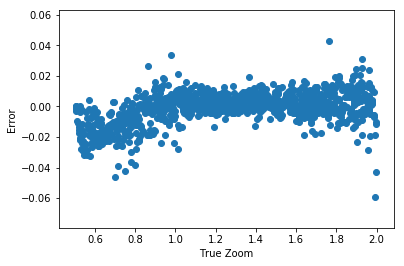

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(true, pred - true)
ax.set_xlabel('True Zoom')
ax.set_ylabel('Error')

[[1.8366336]]


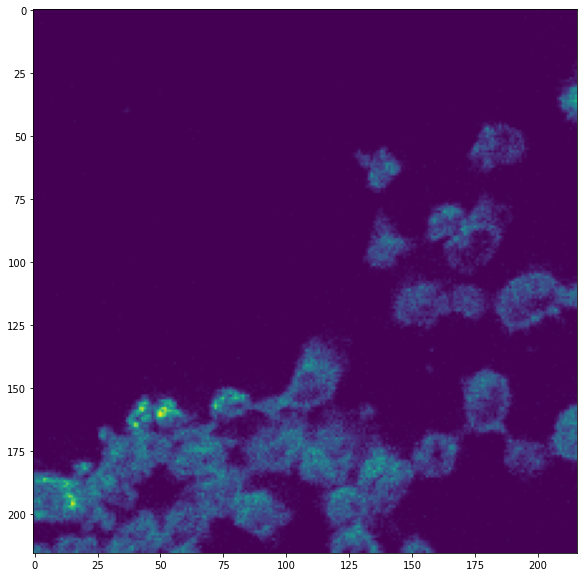

In [30]:
idx = 7

from matplotlib import pyplot as plt
plt.figure(figsize = (10, 10))
plt.imshow(X_val[idx, :, :, 0].astype('float32'))
print(model.predict(X_val[idx:(idx + 1)]))